In [1]:
import mlflow
mlflow.set_tracking_uri("http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/")

In [2]:
# Set or create an experiment
mlflow.set_experiment("Exp 2 - BoW vs TfIdf")

2025/12/11 17:57:40 INFO mlflow.tracking.fluent: Experiment with name 'Exp 2 - BoW vs TfIdf' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-youtube-sentiments-classifier/2', creation_time=1765456079747, experiment_id='2', last_update_time=1765456079747, lifecycle_stage='active', name='Exp 2 - BoW vs TfIdf', tags={}>

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [5]:
# Step 1: Function to run the experiment
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # Step 2: Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")

# Step 6: Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")

2025/12/11 18:02:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/11 18:03:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run BoW_(1, 1)_RandomForest at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/2/runs/3d2ca544d0494cc68ffc3647fc48ff72.
2025/12/11 18:03:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/2.
2025/12/11 18:07:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/11 18:08:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run TF-IDF_(1, 1)_RandomForest at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/2/runs/b6d50bdb65664e2ba4b21767d9b550be.
2025/12/11 18:0

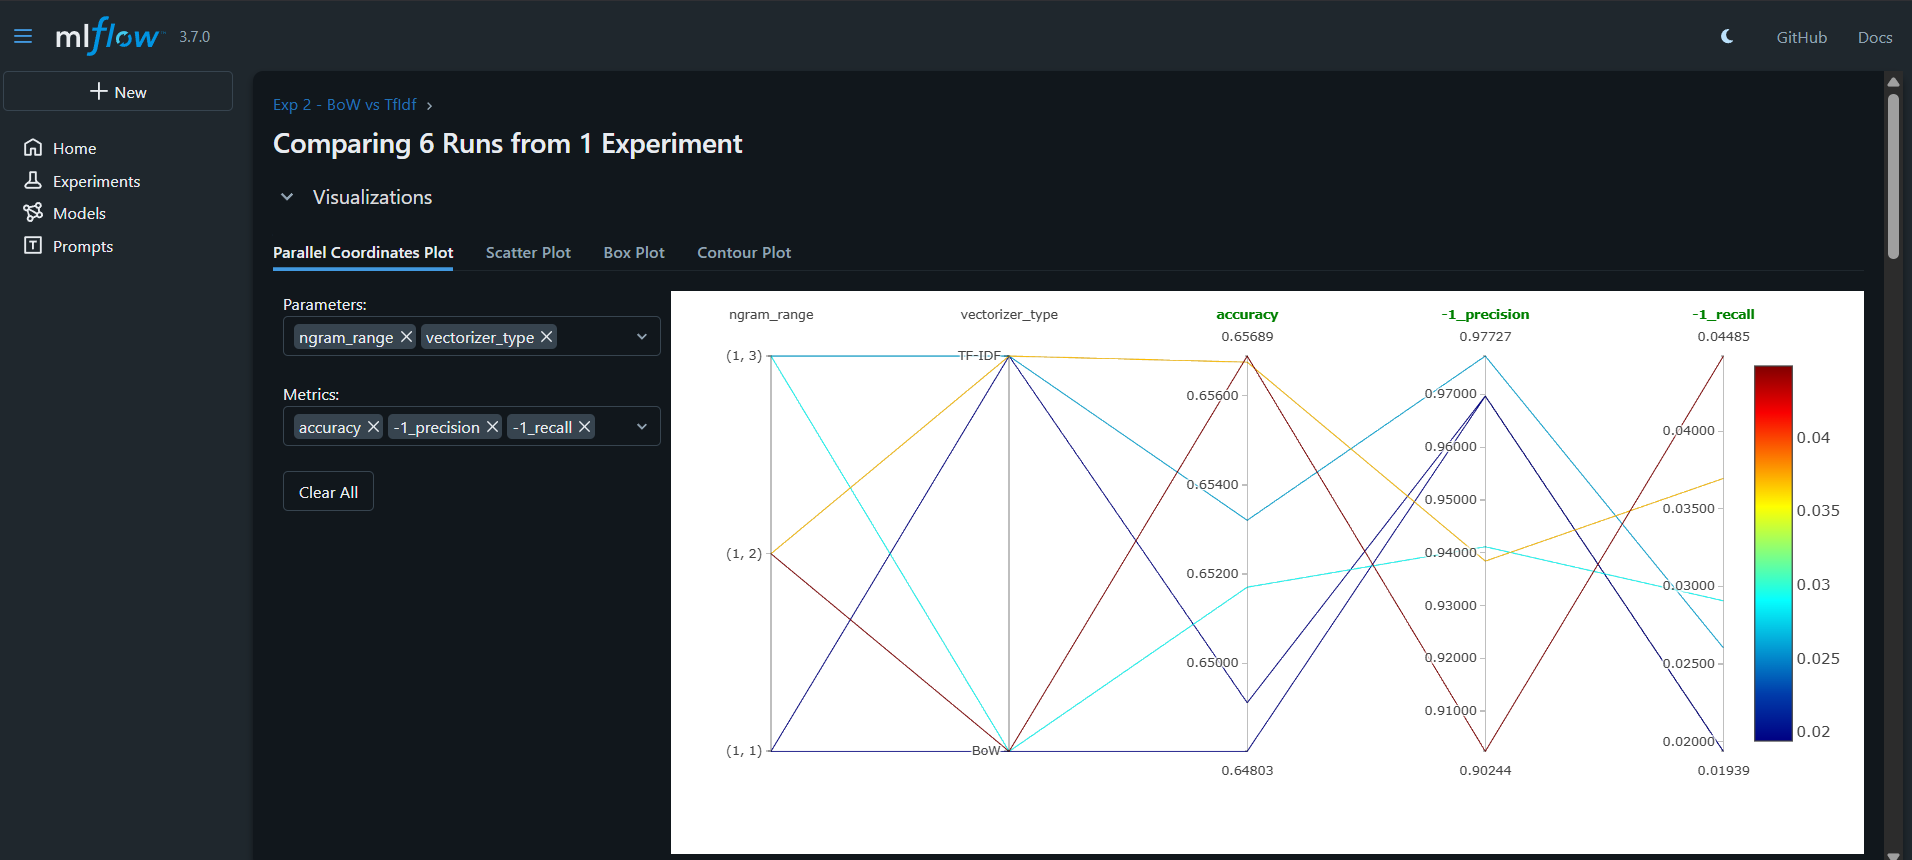

# ✅ **Which model should be selected?**

Looking at your visualization:

* **Accuracy is highest** for the model using:
  **TF-IDF + ngram_range = (1, 3)**

* **Precision is highest** for the same model.

* **Recall is also among the top values** (slightly higher than TF-IDF (1,2), but much higher than BoW models).

This combination creates the most consistently strong performance across *all three* key metrics.

---

# ⭐ **Therefore, your best model = TF-IDF + ngrams (1,3)**

### Why?

### ✔ Best accuracy

### ✔ Best precision

### ✔ Competitive recall

### ✔ TF-IDF naturally handles term importance better than BoW

### ✔ Higher n-grams (1,3) capture context (bi/tri-grams), improving sentiment patterns

This is exactly what sentiment classification benefits from — contextual phrases like:

* "not good"
* "very bad"
* "absolutely loved it"

BoW cannot capture these relationships. TF-IDF (1,3) can.

---

# 🚀 **Short Answer (for your client or documentation)**

**Select the TF-IDF vectorizer with ngram_range = (1,3), as it provides the highest accuracy and precision while maintaining strong recall, making it the most reliable model overall.**